In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
import time
from sklearn import metrics
from sklearn import model_selection


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [50]:
%run SharedFunctions.ipynb

Učitava se prethodno pripremljen skup podataka: 

In [3]:
data = pd.read_csv('data/data_longer.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
data.shape

(223453, 9)

### 1. Podela na trening, test, i validacioni skup

In [5]:
# data.head()

In [5]:
X = data['comment_text']
y = data['target']

In [6]:
X_train_validation, X_test, y_train_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.33, stratify=y, random_state=7)

X_train, X_validation, y_train, y_validation =\
    model_selection.train_test_split(X_train_validation, y_train_validation, test_size=0.2, stratify=y_train_validation, random_state=7)

In [7]:
X_train.shape, X_validation.shape, X_test.shape

((119770,), (29943,), (73740,))

In [8]:
y_train.shape, y_validation.shape, y_test.shape

((119770,), (29943,), (73740,))

### 2. Tokenizacija I vektorizacija teksta

In [9]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina
max_len = 100

In [10]:
word_index, tokenizer = get_vocabulary(max_features, X_train, 'tokenizer_binary.pickle')

In [11]:
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 201164


Sada pravimo skupove za trening, test i validaciju sa vektorizovanim tekstom

In [12]:
X_train = to_sequence(X_train, max_len, tokenizer)
X_test = to_sequence(X_test, max_len, tokenizer)
X_validation = to_sequence(X_validation, max_len, tokenizer)

In [13]:
X_train.shape, X_test.shape, X_validation.shape

((119770, 100), (73740, 100), (29943, 100))

In [14]:
X_train_validation = to_sequence(X_train_validation, max_len, tokenizer)

Kreira se matrica ugnjezdavanja

In [15]:
embedding_matrix = create_embedding_matrix(word_index, max_len)

### 3. Selekcija i evaluacija modela

In [16]:
# Posto su klasa nebalansirane, potrebno je dodeliti im tezine
# tako da se vise kaznjava pogresna klasifikacija manjinske klase

weights = get_weights(y_train_validation)
weights

{0: 0.5558967465969598, 1: 4.97253221735087}

Za podešavanje hiperparametara koristiće se randomizovana unakrsna validacija i keras wrapper 

In [42]:
# random_cv = randomized_search_cv(X_train_validation, y_train_validation, weights, embedding_matrix)

In [30]:
best_params = random_cv.best_params_
best_score = random_cv.best_score_
results = random_cv.cv_results_

In [31]:
cv_data = pd.DataFrame(results)
cv_data.to_csv('data/cv_results.csv')

In [34]:
best_params

{'pool_size': 5,
 'num_of_features': 20000,
 'num_of_classes': 2,
 'maxlen': 100,
 'lr': 0.0001,
 'layers': 0,
 'kernel_size': 7,
 'filters': 128,
 'embedding_matrix': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
          0.82779998,  0.27061999],
        [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
          0.47646999, -0.15983   ],
        ...,
        [ 0.29811999,  0.053545  ,  0.27474001, ..., -0.51871002,
         -0.73246002,  0.54639   ],
        [ 0.48453999, -0.66696   ,  0.31995001, ..., -0.2985    ,
         -0.36061999,  0.23197   ],
        [ 0.25542   ,  0.34395   , -0.28141999, ...,  0.20162   ,
         -0.4488    ,  0.023272  ]]),
 'embedding_dim': 100,
 'dropout_rate': 0.2}

In [32]:
cv_results = pd.read_csv('data/cv_results.csv')

In [33]:
cv_results.head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pool_size,param_num_of_features,param_num_of_classes,param_maxlen,param_lr,...,param_dropout_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0,511.544993,11.070986,6.505815,1.484346,5,20000,2,100,0.00010,...,0.2,"{'pool_size': 5, 'num_of_features': 20000, 'nu...",0.910263,0.919280,0.924957,0.938013,0.919845,0.922472,0.009098,1
1,1,408.505957,3.426609,5.230956,0.161217,5,20000,2,100,0.00010,...,0.4,"{'pool_size': 5, 'num_of_features': 20000, 'nu...",0.908727,0.905153,0.939919,0.922851,0.931568,0.921643,0.013212,2
2,2,211.188902,1.300665,2.762751,0.031314,5,20000,2,100,0.00001,...,0.4,"{'pool_size': 5, 'num_of_features': 20000, 'nu...",0.836322,0.830344,0.827506,0.794670,0.829771,0.823723,0.014816,4
3,3,517.093765,10.530900,6.731384,1.163871,5,20000,2,100,0.00100,...,0.4,"{'pool_size': 5, 'num_of_features': 20000, 'nu...",0.919247,0.890459,0.927228,0.899539,0.919377,0.911170,0.013818,3
4,4,245.557897,13.458993,3.160252,0.085225,3,20000,2,100,0.00001,...,0.4,"{'pool_size': 3, 'num_of_features': 20000, 'nu...",0.776742,0.814748,0.803961,0.765113,0.817915,0.795696,0.021069,5


### 4. Formiranje modela

In [36]:
kernel_size = best_params['kernel_size']
pool_size = best_params['pool_size']
filters = best_params['filters']
dropout_rate = best_params['dropout_rate']
embedding_dim = 100
lr = best_params['lr']
layers = best_params['layers']

In [38]:
binary_model = create_model(num_of_classes = 2, num_of_features = max_features, embedding_dim = embedding_dim, 
                            kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                            dropout_rate = dropout_rate, maxlen = max_len, lr = lr, 
                            embedding_matrix = embedding_matrix, layers=layers)

Model: "sequential_153"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_153 (Embedding)   (None, 100, 100)          2000000   
                                                                 
 conv1d_304 (Conv1D)         (None, 100, 128)          89728     
                                                                 
 max_pooling1d_304 (MaxPooli  (None, 20, 128)          0         
 ng1D)                                                           
                                                                 
 conv1d_305 (Conv1D)         (None, 20, 256)           229632    
                                                                 
 max_pooling1d_305 (MaxPooli  (None, 4, 256)           0         
 ng1D)                                                           
                                                                 
 dropout_152 (Dropout)       (None, 4, 256)         

### 5. Obučavanje modela

In [39]:
# tezinu za klasu 1 podesavamo rucno jer se ispostavlja da
# bolje klasifikuje TP instance ako nije bas tacna proporcija

weights[1] = 3.5

In [40]:
epochs = 15
batch_size = 64

In [41]:
start = time.time()    

binary_history = binary_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                                 validation_data=(X_validation, y_validation), class_weight=weights)
                                 #,callbacks=[early_stop]
                                 
print('Trajanje obucavanja modela binarne klasifikacije: ', time.time() - start)

Epoch 1/15
1872/1872 [==============================] - 67s 35ms/step - loss: 0.3262 - accuracy: 0.8661 - f1_m: 0.5300 - val_loss: 0.2375 - val_accuracy: 0.9110 - val_f1_m: 0.6243
Epoch 2/15
1872/1872 [==============================] - 65s 35ms/step - loss: 0.2415 - accuracy: 0.9056 - f1_m: 0.6266 - val_loss: 0.2163 - val_accuracy: 0.9162 - val_f1_m: 0.6430
Epoch 3/15
1872/1872 [==============================] - 67s 36ms/step - loss: 0.2173 - accuracy: 0.9143 - f1_m: 0.6542 - val_loss: 0.2626 - val_accuracy: 0.8977 - val_f1_m: 0.6171
Epoch 4/15
1872/1872 [==============================] - 67s 36ms/step - loss: 0.1996 - accuracy: 0.9216 - f1_m: 0.6772 - val_loss: 0.2262 - val_accuracy: 0.9129 - val_f1_m: 0.6482
Epoch 5/15
1872/1872 [==============================] - 68s 36ms/step - loss: 0.1843 - accuracy: 0.9275 - f1_m: 0.6991 - val_loss: 0.2157 - val_accuracy: 0.9174 - val_f1_m: 0.6590
Epoch 6/15
1872/1872 [==============================] - 69s 37ms/step - loss: 0.1669 - accuracy: 0.9

Prate se tacnost, funkcija gubitka i F1 mera (jer klase nisu izbalansirane)

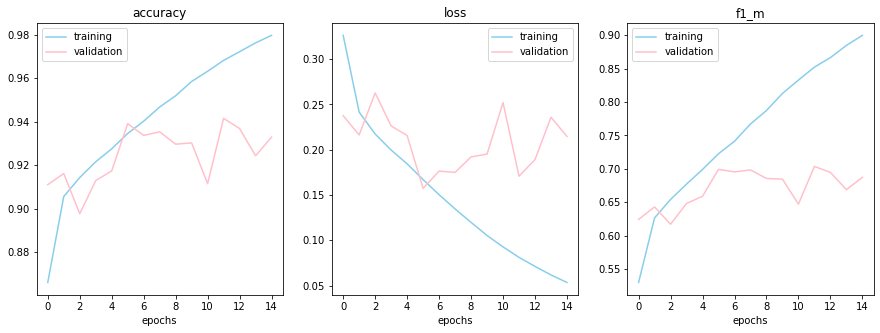

In [43]:
# Grafici koji prikazuju promene metrika tokom treniranja na trening skupu i validacionom skupu kroz epohe 

plot_graphs(binary_history, ['accuracy', 'loss', 'f1_m'])

### 6. Evaluacija modela

In [44]:
scores = binary_model.evaluate(X_test, y_test)
print('Loss: ', scores[0])
print('Test accuracy: ', scores[1])
print('F1: ', scores[2])

2305/2305 [==============================] - 15s 6ms/step - loss: 0.2116 - accuracy: 0.9322 - f1_m: 0.6561
Loss:  0.21164609491825104
Test accuracy:  0.932180643081665
F1:  0.6560590863227844


Predviđanje: 

In [45]:
y_predicted = binary_model.predict(X_test)

2305/2305 [==============================] - 14s 6ms/step


In [46]:
# sigmoidna funkcija:

y_labels = [int(score > 0.5) for score in y_predicted]

In [47]:
# F1 mera je bolja metrika kada su neizbalansirane klase

print('F1: ', metrics.f1_score(y_test, y_labels))

F1:  0.7008434527726266


In [48]:
cf = metrics.confusion_matrix(y_test, y_labels)
print(cf)

[[62881  3445]
 [ 1556  5858]]


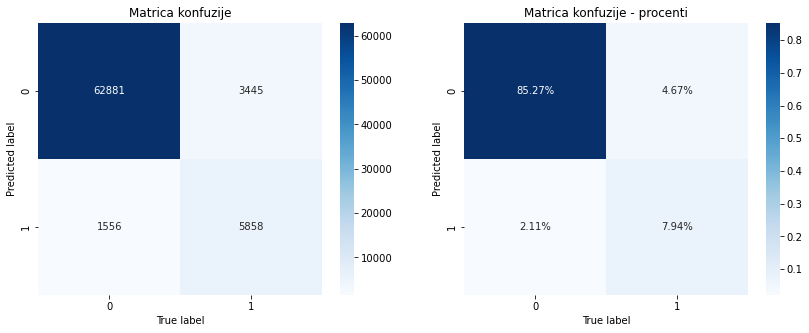

In [51]:
# funkcija koja prikazuje matricu konfuzije i 
# istu tu matricu sa vrednostima u  procentima

plot_cf(cf, 'binary', ['untoxic, toxic'])

In [52]:
print('---------------------- IZVESTAJ -----------------------\n')
print(metrics.classification_report(y_test, y_labels))

---------------------- IZVESTAJ -----------------------

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     66326
           1       0.63      0.79      0.70      7414

    accuracy                           0.93     73740
   macro avg       0.80      0.87      0.83     73740
weighted avg       0.94      0.93      0.94     73740

